In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
import scipy.cluster.hierarchy as hac

In [2]:
import os
os.chdir('C:/Users/veua/Downloads/')
df_raw = pd.read_csv('TYPICAL_HOURLY_VOLUME_DATA.csv')
df_raw.head()

,HMGNS_FLOW_ID,HMGNS_LNK_ID,HMGNS_LNK_DESC,FLOW,DOW,COUNT_TYPE,PERIOD_TYPE,0:00,1:00,2:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
0,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,LONG WKND/PUB HOL/OTHER,1314,835,636,...,5030,5891,6279,6708,5039,3358,2853,2496,2205,1804
1,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,SCHOOL HOLIDAY,1189,597,495,...,5874,7934,8342,8761,7501,4594,3063,2663,2347,1803
2,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,SCHOOL TERM/NORMAL,836,461,316,...,5951,7453,7955,8152,6779,4002,2834,2569,2116,1415
3,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,2,Erte,LONG WKND/PUB HOL/OTHER,1344,742,483,...,5360,6594,7558,8058,7209,4988,3619,3071,2671,2587
4,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,2,Erte,SCHOOL HOLIDAY,1178,620,421,...,5389,6880,7325,7902,6707,4305,3059,2744,2477,2048


In [3]:
df_melt = pd.melt(df_raw,id_vars=df_raw.columns[:7],value_vars = df_raw.columns[7:],var_name='hour_in_day',value_name='traffic_count')
df_melt.head()

,HMGNS_FLOW_ID,HMGNS_LNK_ID,HMGNS_LNK_DESC,FLOW,DOW,COUNT_TYPE,PERIOD_TYPE,hour_in_day,traffic_count
0,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,LONG WKND/PUB HOL/OTHER,0:00,1314
1,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,SCHOOL HOLIDAY,0:00,1189
2,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,SCHOOL TERM/NORMAL,0:00,836
3,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,2,Erte,LONG WKND/PUB HOL/OTHER,0:00,1344
4,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,2,Erte,SCHOOL HOLIDAY,0:00,1178


In [4]:
df_base = df_melt.loc[(df_melt['HMGNS_LNK_DESC'].notna()) &
                      (df_melt['HMGNS_LNK_DESC'].str.contains('^[ ]MONASH FREEWAY',flags=re.I, regex=True)), :].copy()
df_base.head()

,HMGNS_FLOW_ID,HMGNS_LNK_ID,HMGNS_LNK_DESC,FLOW,DOW,COUNT_TYPE,PERIOD_TYPE,hour_in_day,traffic_count
0,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,LONG WKND/PUB HOL/OTHER,0:00,1314
1,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,SCHOOL HOLIDAY,0:00,1189
2,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,SCHOOL TERM/NORMAL,0:00,836
3,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,2,Erte,LONG WKND/PUB HOL/OTHER,0:00,1344
4,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,2,Erte,SCHOOL HOLIDAY,0:00,1178


In [5]:
df_base.shape

(37296, 9)

In [6]:
df_base.describe()

,HMGNS_FLOW_ID,HMGNS_LNK_ID,DOW,traffic_count
count,37296.000000,37296.000000,37296.000000,37296.000000
mean,4579.337838,3532.540541,4.000000,2883.362264
std,4474.517361,3664.124749,2.000027,2101.628254
min,2.000000,2.000000,1.000000,34.000000
25%,368.000000,343.000000,2.000000,1004.000000
50%,6566.500000,441.000000,4.000000,2538.000000
75%,7470.000000,7682.000000,6.000000,4507.000000
max,15480.000000,8726.000000,7.000000,10801.000000


In [7]:
df_base['direction'] = df_base['FLOW'].apply(lambda x: 'Outbound' if x in ['EAST BOUND', 'SOUTH EAST BOUND', 'SOUTH BOUND']
                                            else 'Inbound')

In [8]:
df_pivot = df_base.pivot_table(columns='direction', index=['DOW', 'hour_in_day', 'HMGNS_LNK_DESC'], values='traffic_count', aggfunc='mean')
df_pivot.reset_index(inplace=True)
df_pivot['hour_in_day'] = df_pivot['hour_in_day'].str.split(':', expand=True).astype('int64')

In [9]:
df_pivot.head()

direction,DOW,hour_in_day,HMGNS_LNK_DESC,Inbound,Outbound
0,1,0,MONASH FREEWAY btwn BELGRAVE-HALLAM ROAD & MO...,359.666667,568.000000
1,1,0,MONASH FREEWAY btwn BLACKBURN ROAD & MONASH F...,640.333333,1179.333333
2,1,0,MONASH FREEWAY btwn BURKE ROAD & MONASH FREEW...,579.666667,1113.000000
3,1,0,MONASH FREEWAY btwn Blackburn Rd & Ferntree G...,616.333333,1144.666667
4,1,0,MONASH FREEWAY btwn Blackburn Rd & Forster Rd,643.666667,1266.333333


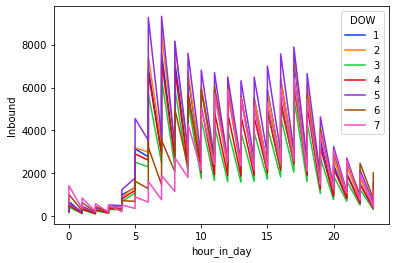

In [10]:
import seaborn

lp = seaborn.lineplot(data=df_pivot,
                      x='hour_in_day', y='Inbound', hue='DOW', markers=True, dashes=df_pivot, estimator=None,
                      legend='full', palette=seaborn.color_palette("bright", n_colors=7))
plt.show()

<b>From the above graph ("Inbound vs hour_in_day"), we can not make out whether any difference exists in the inbound traffic over weekdays(1-Mondays, 2-Tuesdays, 3-Wednesdays, 4-Thursdays, 5-Fridays) 
and weekends(6-Saturdays, 7-Sundays). So i am going to check out for just one specific homegeneous link description.</b>

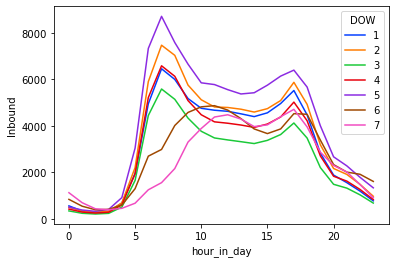

In [11]:
import seaborn

lp = seaborn.lineplot(data=df_pivot.loc[df_pivot['HMGNS_LNK_DESC'] == ' MONASH FREEWAY btwn Toorak Rd & Bourke Rd', :],
                      x='hour_in_day', y='Inbound', hue='DOW', markers=True, dashes=df_pivot, estimator=None,
                      legend='full', palette=seaborn.color_palette("bright", n_colors=7))
plt.show()

<b>We can cleary observe that the inbound traffic is more on weekdays compared to weekends. The traffic gets heavy over peak hours in the morning (around 6am to 10 am) and again in the evening(4pm to 8pm).</b>

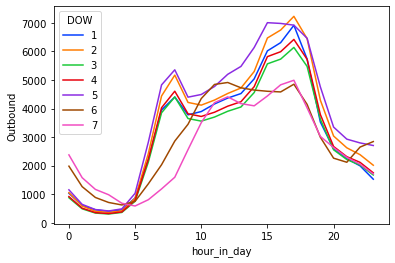

In [12]:
import seaborn

lp = seaborn.lineplot(data=df_pivot.loc[df_pivot['HMGNS_LNK_DESC'] == ' MONASH FREEWAY btwn Toorak Rd & Bourke Rd', :],
                      x='hour_in_day', y='Outbound', hue='DOW', markers=True, dashes=df_pivot, estimator=None,
                      legend='full', palette=seaborn.color_palette("bright", n_colors=7))
plt.show()

<b> We can clearly observe that the outbound traffic is more on weekdays compared to weekends. 
The traffic gets heavy over peak hours in the morning (around 6am to 10 am) and again in the evening(4pm to 8pm).</b>

# Hypothesis Testing

<b>We are going to  examine whether any difference exists in peak hour traffic volumes over weekdays.</b>

For this purpose, we will take the sum of the averages of the 6AM, 7AM, 8AM and 9AM hour for every location for the morning peak observation, and the sum of the averages of the 3PM, 4PM, 5PM and 6PM hour for every location for the afternoon peak observation. 

The data has been transformed to add two new columns for morning and afternoon peak levels.

In [13]:
df_raw.columns

Index(['HMGNS_FLOW_ID', 'HMGNS_LNK_ID', 'HMGNS_LNK_DESC', 'FLOW', 'DOW',
       'COUNT_TYPE', 'PERIOD_TYPE', '0:00', '1:00', '2:00', '3:00', '4:00',
       '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00',
       '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'],
      dtype='object')

In [14]:
df_monash = df_raw[df_raw['HMGNS_LNK_DESC'].notna() & df_raw["HMGNS_LNK_DESC"].str.contains('^[ ]MONASH FREEWAY',flags=re.I, regex=True)]
df_monash.head()

,HMGNS_FLOW_ID,HMGNS_LNK_ID,HMGNS_LNK_DESC,FLOW,DOW,COUNT_TYPE,PERIOD_TYPE,0:00,1:00,2:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
0,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,LONG WKND/PUB HOL/OTHER,1314,835,636,...,5030,5891,6279,6708,5039,3358,2853,2496,2205,1804
1,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,SCHOOL HOLIDAY,1189,597,495,...,5874,7934,8342,8761,7501,4594,3063,2663,2347,1803
2,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,SCHOOL TERM/NORMAL,836,461,316,...,5951,7453,7955,8152,6779,4002,2834,2569,2116,1415
3,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,2,Erte,LONG WKND/PUB HOL/OTHER,1344,742,483,...,5360,6594,7558,8058,7209,4988,3619,3071,2671,2587
4,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,2,Erte,SCHOOL HOLIDAY,1178,620,421,...,5389,6880,7325,7902,6707,4305,3059,2744,2477,2048


In [15]:
df_monash_weekday = df_monash[df_monash["PERIOD_TYPE"]=='SCHOOL TERM/NORMAL']
df_monash_weekday =  df_monash_weekday[df_monash_weekday["DOW"].isin([1, 2, 3, 4, 5])]

In [16]:
df_monash_weekday["morning_peak"] = df_monash_weekday['6:00'] + df_monash_weekday['7:00'] + df_monash_weekday['8:00'] + df_monash_weekday['9:00']
df_monash_weekday["evening_peak"] = df_monash_weekday['16:00'] + df_monash_weekday['17:00'] + df_monash_weekday['18:00'] + df_monash_weekday['19:00']
df_monash_weekday.head()

,HMGNS_FLOW_ID,HMGNS_LNK_ID,HMGNS_LNK_DESC,FLOW,DOW,COUNT_TYPE,PERIOD_TYPE,0:00,1:00,2:00,...,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00,morning_peak,evening_peak
2,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,1,Erte,SCHOOL TERM/NORMAL,836,461,316,...,7955,8152,6779,4002,2834,2569,2116,1415,18672,26888
5,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,2,Erte,SCHOOL TERM/NORMAL,915,490,343,...,7755,7758,6882,4489,3283,3025,2499,1791,18949,26884
8,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,3,Erte,SCHOOL TERM/NORMAL,905,485,340,...,7677,7679,6812,4444,3250,2994,2474,1773,18758,26612
11,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,4,Erte,SCHOOL TERM/NORMAL,942,504,354,...,7990,7993,7090,4625,3383,3116,2575,1845,19524,27698
14,2,7581,MONASH FREEWAY btwn MONASH FREEWAY Offramp & ...,EAST BOUND,5,Erte,SCHOOL TERM/NORMAL,1163,645,461,...,7786,7530,7041,5263,3757,3399,3177,3150,18787,27620


# Chi-Square Test

Our null hypothesis is that there is no variation in peak traffic levels over week days. 
That is, each day is rougly 20% of the total peak traffic for week days. 

The alternative hypothesis is that there is a variation in peak traffic levels across five weekdays.

<Figure size 2160x2160 with 0 Axes>

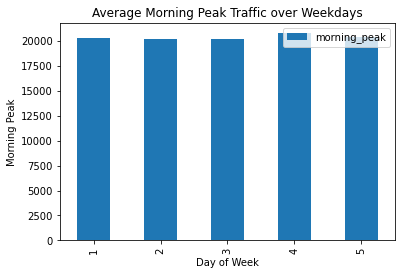

In [27]:
df_monash_weekday_average_morning = df_monash_weekday.groupby('DOW').agg({'morning_peak': 'mean'})

plt.figure(figsize=(30, 30))
df_monash_weekday_average_morning.plot(kind="bar")
plt.title('Average Morning Peak Traffic over Weekdays')
plt.ylabel('Morning Peak')
plt.xlabel('Day of Week')
plt.show()

<Figure size 2160x2160 with 0 Axes>

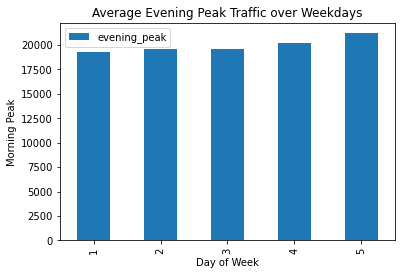

In [28]:
df_monash_weekday_average_evening = df_monash_weekday.groupby('DOW').agg({'evening_peak': 'mean'})
plt.figure(figsize=(30, 30))
df_monash_weekday_average_evening.plot(kind="bar")
plt.title('Average Evening Peak Traffic over Weekdays')
plt.ylabel('Morning Peak')
plt.xlabel('Day of Week')
plt.show()

In [29]:
from scipy.stats import chisquare
chisquare(df_monash_weekday_average_morning, f_exp=[1/5, 1/5, 1/5, 1/5, 1/5])

Power_divergenceResult(statistic=array([1.03493729e+10, 1.03493729e+10, 1.03493729e+10, 1.03493729e+10,
       1.03493729e+10]), pvalue=array([0., 0., 0., 0., 0.]))

In [30]:
chisquare(df_monash_weekday_average_evening, f_exp=[1/5, 1/5, 1/5, 1/5, 1/5])

Power_divergenceResult(statistic=array([9.9790655e+09, 9.9790655e+09, 9.9790655e+09, 9.9790655e+09,
       9.9790655e+09]), pvalue=array([0., 0., 0., 0., 0.]))

<b> As you can observe from both chi-square tests, p-value in both cases is less than 0.05. So we reject the null hypothesis. Therefore we can conclude that the distribution of morning peak hour traffic and evening peak hour traffic are not equally distributed across weekdays.</b>

# Clustering

I am going to cluster all time series data that is from 0th hour to 23rd hour for every row or sample. 

In [17]:
df_raw = pd.read_csv('C:/Users/veua/Downloads/TYPICAL_HOURLY_VOLUME_DATA.csv')
df_raw = df_raw.dropna(axis=0, how='any')
df_raw.shape

(224978, 31)

# Mini Batch K-Means

K-means is one of the most popular clustering algorithms, mainly because of its good time performance. With the increasing size of the datasets being analyzed, the computation time of K-means increases because of its constraint of needing the whole dataset in main memory. For this reason, several methods have been proposed to reduce the temporal and spatial cost of the algorithm. A different approach is the Mini batch K-means algorithm.

Mini Batch K-means algorithm's main idea is to use small random batches of data of a fixed size, so they can be stored in memory. Each iteration a new random sample from the dataset is obtained and used to update the clusters and this is repeated until convergence. This speeds up the algorithm typically by a factor of three or four and makes it possible to cluster huge datasets that do not fit in memory.



In [20]:
df_raw.columns

Index(['HMGNS_FLOW_ID', 'HMGNS_LNK_ID', 'HMGNS_LNK_DESC', 'FLOW', 'DOW',
       'COUNT_TYPE', 'PERIOD_TYPE', '0:00', '1:00', '2:00', '3:00', '4:00',
       '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00',
       '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'],
      dtype='object')

In [21]:
df_clus = df_raw.loc[:, '0:00':'23:00']
df_clus = df_clus.dropna(axis=0, how='any')
df_clus.head()

,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,8:00,9:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
0,1314,835,636,562,531,701,1416,2544,3169,2965,...,5030,5891,6279,6708,5039,3358,2853,2496,2205,1804
1,1189,597,495,391,526,1173,3089,5196,6032,4438,...,5874,7934,8342,8761,7501,4594,3063,2663,2347,1803
2,836,461,316,299,442,1080,2999,5226,5967,4480,...,5951,7453,7955,8152,6779,4002,2834,2569,2116,1415
3,1344,742,483,423,414,722,2108,4219,5633,4056,...,5360,6594,7558,8058,7209,4988,3619,3071,2671,2587
4,1178,620,421,359,422,902,2520,4594,5382,4112,...,5389,6880,7325,7902,6707,4305,3059,2744,2477,2048


In [22]:
df_clus.shape

(224978, 24)

For n_clusters = 2, silhouette score is 0.72)
For n_clusters = 3, silhouette score is 0.60)
For n_clusters = 4, silhouette score is 0.53)
For n_clusters = 5, silhouette score is 0.58)
For n_clusters = 6, silhouette score is 0.49)
For n_clusters = 7, silhouette score is 0.49)
For n_clusters = 8, silhouette score is 0.38)
For n_clusters = 9, silhouette score is 0.46)


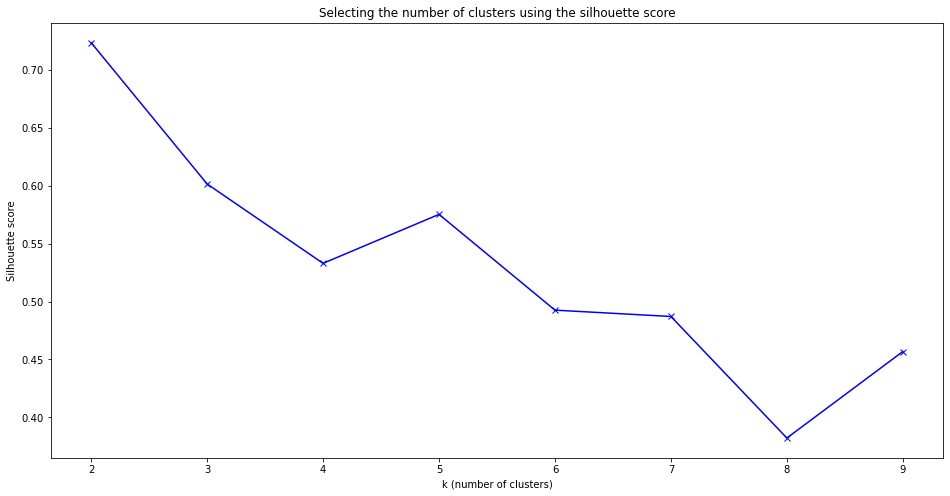

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_clus)
    centers = clusterer.cluster_centers_

    score = silhouette_score(df_clus, preds, sample_size=100)
    silhouette_scores.append(score)
    print("For n_clusters = {}, silhouette score is {:.2f})".format(n_clusters, score))

plt.figure(figsize=(16,8))
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette score')
plt.title('Selecting the number of clusters using the silhouette score')
plt.show()
   

<b> From above graph, we can see that silhouette score is the largest at k = 2. So I will choose k = 2.</b>

In [24]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=2, random_state=0,batch_size=100)
kmeans1 = kmeans.partial_fit(df_clus.iloc[0:int(len(df_clus)),:])
centroids = kmeans1.cluster_centers_
labels = kmeans1.labels_
pred_clusters = kmeans1.predict(df_clus)
print("Number of clusters:", len(centroids))
print("Predicted Clusters:", pred_clusters)


Number of clusters: 2
Predicted Clusters: [1 1 1 ... 0 0 0]


In [25]:
print("Printing Cluster Centroids", centroids)

Printing Cluster Centroids [[  80.77323967   50.63915451   36.84638286   33.93627296   44.38592472
    97.96620432  235.23920848  363.02020881  441.93208394  410.3273745
   431.24015512  460.22931215  469.95505495  462.42459539  477.18537319
   527.95466623  555.36801163  561.23790513  442.23905299  311.61089693
   235.41221126  199.7786543   163.0238399   122.32521139]
 [ 721.21280304  433.15734432  333.24370147  337.24306766  532.99001743
  1371.82601806 3087.15385834 3883.42544763 3948.49659325 3581.31817462
  3561.94438282 3638.76121058 3659.57518618 3677.43844082 3912.49073047
  4390.18380605 4673.92663603 4833.52638251 3965.00950721 2726.58168278
  2037.49595944 1778.15734432 1520.79733798 1174.06591665]]


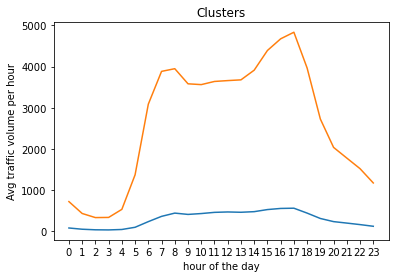

In [26]:
for center in centroids:
    plt.plot(center)
    plt.xlabel("hour of the day")
    plt.xticks(range(0, 24))
    plt.ylabel("Avg traffic volume per hour")
    plt.title("Clusters")

<b> From the above graph, we can conclude that blue line represents the cluster that contains average traffic volumes per hour for SCHOOL HOLIDAYS/LONG WEEKEENDS/PUBLIC HOLIDAYS and orange line represents average traffic per hour for SCHOOL DAYS/NORMAL WEEKDAYS. We can observe that average traffic volumes per hour are higher during weekdays as people go about their normal lives. </b>


# BIRCH (Balanced Iterative Reducing and Clustering using Hierarchy)

The BIRCH algorithm was designed specifically for very large datasets, and it can be faster than K-Means, with similar results, as long as the number of features is not too large. During training, it builds a tree structure containing just enough information to quickly assign each new instance to a cluster, without having to store all the instances in the tree: this approach allows it to use limited memory, while handling huge datasets.

Parameters of BIRCH Algorithm:

threshold :  threshold is the maximum number of data points a sub-cluster in the leaf node of the CF tree can hold.

branching_factor : This parameter specifies the maximum number of CF sub-clusters in each node (internal node).

n_clusters : The number of clusters to be returned after the entire BIRCH algorithm is complete i.e., number of clusters after the final clustering step. 
If set to None, the final clustering step is not performed and intermediate clusters are returned.

In [ ]:
#Here i specified some values for parameters.
from sklearn.cluster import Birch
brc = Birch(n_clusters=None, branching_factor = 50, threshold=1.5)
brc.fit(df_clus)

In [ ]:
predictions = brc.predict(df_clus)
predictions